# Download and unzip the PascalVoc dataset

In [1]:
import torchvision
# train_dataset =torchvision.datasets.VOCSegmentation(root='./data',year='2012',download=True,image_set='train')
# val_dataset = torchvision.datasets.VOCSegmentation(root='./data',year='2012',download=True,image_set='val')
# test_dataset = torchvision.datasets.VOCSegmentation(root='./data',year='2007',download=True,image_set='test')

# train_dataset =torchvision.datasets.SBDataset(root='./data',mode='segmentation',download=True,image_set='train')
# val_dataset = torchvision.datasets.SBDataset(root='./data',mode='segmentation',download=True,image_set='val')
# test_dataset = torchvision.datasets.SBDataset(root='./data',mode='segmentation',download=True,image_set='test')

In [2]:
# torchvision.datasets.SBDataset(root: str, image_set: str = 'train', mode: str = 'boundaries', download: bool = False, transforms: Optional[Callable] = None)

In [3]:
!cd data

In [4]:
# !wget http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
import torch
from torch import optim

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [5]:
# !tar -xvf VOCtest_06-Nov-2007.tar

# Data Preparation

run the code below to get thre dataloader objects, namely: train_loader, val_loader and test_loader

In [6]:
import os
from PIL import Image
from torch.utils import data
import torchvision.transforms as transforms
import random

num_classes = 21
ignore_label = 255
root = './data'

'''
color map
0=background, 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle # 6=bus, 7=car, 8=cat, 9=chair, 10=cow, 11=diningtable,
12=dog, 13=horse, 14=motorbike, 15=person # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
'''


#Feel free to convert this palette to a map
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]  #3 values- R,G,B for every class. First 3 values for class 0, next 3 for
#class 1 and so on......

'''
Depending on the mode, train or val or test, the function reads the train.txt, val.txt and test.txt files and returns a list of tuples of the form
(image_path, mask_path) for each image in the dataset, where image_path is the path to the image and mask_path is the path to the mask for that image. 
'''
def make_dataset(mode):
    assert mode in ['train', 'val', 'train2007', 'val2007', 'test', ]
    items = []
    if mode == 'train':
        img_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'JPEGImages')
        mask_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root, 'VOCdevkit', 'VOC2012', 'ImageSets', 'Segmentation', 'train.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    elif mode == 'val':
        img_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'JPEGImages')
        mask_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root, 'VOCdevkit', 'VOC2012', 'ImageSets', 'Segmentation', 'val.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    elif mode == 'train2007':
        img_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'JPEGImages')
        mask_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root, 'VOCdevkit', 'VOC2007', 'ImageSets', 'Segmentation', 'train.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    elif mode == 'val2007':
        img_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'JPEGImages')
        mask_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root, 'VOCdevkit', 'VOC2007', 'ImageSets', 'Segmentation', 'val.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    else:
        img_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'JPEGImages')
        mask_path = os.path.join(root, 'VOCdevkit', 'VOC2007', 'SegmentationClass')
        data_list = [l.strip('\n') for l in open(os.path.join(
            root, 'VOCdevkit', 'VOC2007', 'ImageSets', 'Segmentation', 'test.txt')).readlines()]
        for it in data_list:
            item = (os.path.join(img_path, it + '.jpg'), os.path.join(mask_path, it + '.png'))
            items.append(item)
    return items




'''
The class VOC is a subclass of the class torch.utils.data.Dataset. It overrides the __len__ and __getitem__ methods.
The __len__ method returns the length of the dataset, i.e. the number of images in the dataset.
The __getitem__ method returns the image and the mask for the given index.
'''

class VOC(data.Dataset):
    def __init__(self, mode, transform=None, target_transform=None, common_transform=None):
        self.imgs = make_dataset(mode)
        if len(self.imgs) == 0:
            raise RuntimeError('Found 0 images, please check the data set')
        self.mode = mode
        self.transform = transform
        self.target_transform = target_transform
        self.common_transform = common_transform
        self.width = 224
        self.height = 224

    def __getitem__(self, index):
        
        img_path, mask_path = self.imgs[index]
        img = Image.open(img_path).convert('RGB').resize((self.width, self.height))
        mask = Image.open(mask_path).resize((self.width, self.height))

        if self.common_transform is not None:
            img, mask = self.common_transform((img,mask)) 

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            mask = self.target_transform(mask)

        mask[mask==ignore_label]=0

        return img, mask

    def __len__(self):
        return len(self.imgs)


if __name__=="__main__":
#     voc = VOC("train")

#     print(len(voc))
    pass

In [7]:
import numpy as np 
import torch
class MaskToTensor(object):
    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.int32)).long()


mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# common_transform = transforms.Compose([
#     # voc.MirrorFlip(0.5),
#     # voc.Rotate(10),
#     # voc.CenterCrop(180)
# ])

input_transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize(*mean_std)
])

target_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    MaskToTensor()
])

# augmented_train_dataset =voc.VOC('train', transform=input_transform, target_transform=target_transform, common_transform=common_transform)
# augmented_val_dataset = voc.VOC('val', transform=input_transform, target_transform=target_transform, common_transform=common_transform)
# augmented_test_dataset = voc.VOC('test', transform=input_transform, target_transform=target_transform, common_transform=common_transform)

original_train_dataset =VOC('train', transform=input_transform, target_transform=target_transform)
original_val_dataset = VOC('val', transform=input_transform, target_transform=target_transform)
original_test_dataset = VOC('test', transform=input_transform, target_transform=target_transform)


In [8]:
from torch.utils.data import DataLoader, ConcatDataset

NUM_WORKERS = 4
PREFETCH_FACTOR = 2 # improves data transfer speed between GPU and CPU and reduces GPU wait time
train_loader = DataLoader(dataset=original_train_dataset, batch_size= 16, shuffle=True, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory=True)
val_loader = DataLoader(dataset=original_val_dataset, batch_size= 16, shuffle=False, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory=True)
test_loader = DataLoader(dataset=original_test_dataset, batch_size= 16, shuffle=False, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory=True)


# end of data section

In [9]:
# for images, masks in train_loader:
#   image = images.to(device)
#   mask = masks.to(device)
#   break


import matplotlib.pyplot as plt
import numpy as np

# # Assuming data is a tuple (image, label)
# image = images[0]
# # image = masks[0]
# # Convert the tensor image to NumPy array and transpose the dimensions
# image = image.numpy().transpose((1, 2, 0))

# # Denormalize the image (if it was normalized during transformation)
# mean = (0.5, 0.5, 0.5)  # Mean used for normalization
# std = (0.5, 0.5, 0.5)  # Standard deviation used for normalization
# image = image * std + mean

# # Clip the pixel values to [0, 1] range in case of any numerical instability
# image = np.clip(image, 0, 1)

# # Plot the image
# plt.imshow(image)
# plt.axis('off')
# plt.show()

# utils 

In [10]:
def iou(pred, target, n_classes = 21):
    target[target==255] = 0

    ious = []

    for cls in range(n_classes):
        intersection = torch.sum((pred == cls) & (target == cls)).item()
        union = torch.sum(pred == cls) + torch.sum(target == cls) - intersection
        union = union.item()
        if union!=0:
            ious.append(intersection/union)

    ious = np.array(ious)
    return ious

'''
returns pixel accuracy for the batch
'''
def pixel_acc(pred, target):
    target[target==255] = 0
    
    correct = torch.sum(pred==target).item()
    total_predictions = target.shape[0]*target.shape[1]*target.shape[2]
    return correct/total_predictions

In [11]:
import time
import torch.nn.functional as F

criterion = torch.nn.CrossEntropyLoss()

def train(model=None):

    model_ = model 
    torch.autograd.set_detect_anomaly(True)
    
    best_iou_score = 0.0

    trainEpochLoss = []
    trainEpochAccuracy = []
    trainEpochIOU = []
    valEpochLoss = []
    valEpochAccuracy = []
    valEpochIOU = []

    for epoch in range(epochs):

        # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
        train_loss = []
        train_acc = []
        train_iou = []

        ts = time.time()
        for iter, (inputs, labels) in enumerate(train_loader):
            #   reset optimizer gradients
            optimizer.zero_grad()


            # both inputs and labels have to reside in the same device as the model's
            inputs =  inputs.to(device)#  transfer the input to the same device as the model's
            labels =   labels.to(device)#  transfer the labels to the same device as the model's

            trainOutputs =  model_.forward(inputs) #   Compute outputs. we will not need to transfer the output, it will be automatically in the same device as the model's!
            trainOutputs = F.softmax(trainOutputs)
            loss =  criterion(trainOutputs,labels)  #  calculate loss
            loss.backward()

            with torch.no_grad():
                # To compute accuracy and IOU
                # outputs = F.log_softmax(model_(inputs), dim=1)
                _, pred = torch.max(trainOutputs, dim=1)
                
                train_iou += [np.mean(iou(pred, labels))]
                train_acc += [pixel_acc(pred, labels)]
                train_loss.append(loss.item())

            optimizer.step()

            if iter % 10 == 0:
                print(f"==> epoch{epoch}, iter{iter}, Train set=> loss: {train_loss[-1]}, IOU: {train_iou[-1]}, Acc: {train_acc[-1]}")

        # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))

        val_loss, val_iou, val_acc = val(epoch,model_)
        
        
        
        ##### Plotting values
        trainEpochLoss.append(np.mean(np.asarray(train_loss)))
        trainEpochIOU.append(np.mean(np.asarray(train_iou)))
        trainEpochAccuracy.append(np.mean(train_acc))
        valEpochLoss.append(val_loss)
        valEpochIOU.append(val_iou)
        valEpochAccuracy.append(val_acc)
        
    return trainEpochLoss, trainEpochIOU, trainEpochAccuracy, valEpochLoss, valEpochIOU, valEpochAccuracy

    # plots(trainEpochLoss, trainEpochAccuracy, trainEpochIOU, valEpochLoss, valEpochAccuracy, valEpochIOU, best_iter, saveLocation=saveLocation)


In [12]:
def val(epoch, model=None):
    model_ = model
    model_.eval() # Put in eval mode (disables batchnorm/dropout) !
    
    losses = []
    mean_iou_scores = []
    accuracy = []

    with torch.no_grad(): # we don't need to calculate the gradient in the validation/testing
        num_iter = 0
        for iter, (inputs, labels) in enumerate(val_loader):
            
            # both inputs and labels have to reside in the same device as the model's
            inputs =  inputs.to(device)#  transfer the input to the same device as the model's
            labels =   labels.to(device)#  transfer the labels to the same device as the model's


            outputs = F.softmax(model_(inputs), dim=1)
#             valoutputs = model_(inputs)
            valloss = criterion(outputs, labels)
            
            num_iter += 1
            _, pred = torch.max(outputs, dim=1)
            mean_iou_scores += [np.mean(iou(pred, labels))]
            accuracy += [pixel_acc(pred, labels)]
            losses += [valloss.item()]

    # print(mean_iou_scores, accuracy)
    print(f"=========> Loss at epoch {epoch} is {np.mean(losses)}")
    print(f"=========> IoU at epoch {epoch} is {np.mean(mean_iou_scores)}")
    print(f"=========> Pixel acc at epoch {epoch} is {np.mean(accuracy)}")

    model_.train() #TURNING THE TRAIN MODE BACK ON TO ENABLE BATCHNORM/DROPOUT!!

    return np.mean(losses), np.mean(mean_iou_scores), np.mean(accuracy)

# SSL models

In [13]:
from torch import nn
num_scales = 3
scale_factor = 2

# Define the network architecture with feature pyramid
class CompletionModel(nn.Module):
    def __init__(self, num_scales=3):
        super(CompletionModel, self).__init__()
        self.num_scales = num_scales

        # Define layers for each scale in the feature pyramid
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.channel_reducers = nn.ModuleList()  # 1x1 convolution layers to reduce channels
#         self.downsamplers = nn.ModuleList()
#         self.upsamplers = nn.ModuleList()
        
        for i in range(num_scales):
            encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            )
            self.encoders.append(encoder)

            decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            )
            self.decoders.append(decoder)
            
            channel_reducer = nn.Conv2d(3, 512, kernel_size=1)  # 1x1 convolution layer to reduce channels
            self.channel_reducers.append(channel_reducer)
            
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)
        self.downsampler = nn.Upsample(scale_factor=1/scale_factor, mode='bilinear', align_corners=False)
            

    def forward(self, x):
        # Initialize list to store features from each scale
        features = []
        #print(f"x.shape: {x.shape}")

        # Forward pass through each scale in the feature pyramid
        for i in range(self.num_scales):
            encoder_output = self.encoders[i](x)
            features.append(encoder_output)
            #print(f"Feature size at {i}th scale: {features[-1].shape}")
            x = self.downsampler(x)

        # Decode the concatenated features
        shape_feats = list(features[-1].shape)
        shape_feats[1] = 3
        prev_output = None#torch.zeros(shape_feats).to(device)
        
        for i in range(self.num_scales):
            decoder_output = self.decoders[i](features[self.num_scales - i - 1])
            #print(f"decoder output shape: {decoder_output.shape}")
            if prev_output is None:
                prev_output = self.upsampler(decoder_output)
                #print(f"prev output is none: prev_output.shape : {prev_output.shape}")
            else:
                #prev_output = self.channel_reducers[i](prev_output)
                #print(f"prev_output.shape : {prev_output.shape}")
                prev_output = self.upsampler(prev_output+decoder_output)
        
        #print(decoder_output.shape)
        return decoder_output

## Self supervised training

In [14]:
# Set hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
image_size = 28

# Gaussian Pyramid Constants
num_scales = 3
scale_factor = 2
batch_size = 64


In [17]:
ssl_transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(*mean_std)
])

target_transform = transforms.Compose([
    MaskToTensor()
])

combined_dataset = torchvision.datasets.OxfordIIITPet('./data', split="trainval", transform=ssl_transform, target_transform=target_transform, download=True)

# ssl_dataset_train = VOC('train', transform=ssl_transform, target_transform=target_transform)
# ssl_dataset_val = VOC('val', transform=ssl_transform, target_transform=target_transform)
# ssl_dataset_test = VOC('test', transform=ssl_transform, target_transform=target_transform)

# combined_dataset = torch.utils.data.ConcatDataset([ssl_dataset_train, ssl_dataset_val, ssl_dataset_test])
ssl_dataloader = DataLoader(dataset=combined_dataset, batch_size= 16, shuffle=True, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory=True)

100.0%


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100.0%


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [18]:
model = CompletionModel().to(device)
# model.load_state_dict(torch.load('ssl_model.pth'))

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 30

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in ssl_dataloader:
        images = images.to(device)#.unsqueeze(0)
        #print(images.shape)
        
        occluded_image = images.clone()
        _,_, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        # Forward pass and loss calculation
        completion_images = model(occluded_image.to(device))
        loss = criterion(completion_images[:, :, y:y + h // 2, x:x + w // 2], images[:, :, y:y + h // 2, x:x + w // 2])
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Compute the average loss for the epoch
    average_loss = running_loss / len(ssl_dataloader)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Generate completions for test images
model.eval()
pass

Epoch [1/30], Loss: 1.1712
Epoch [2/30], Loss: 1.0959
Epoch [3/30], Loss: 1.0594
Epoch [4/30], Loss: 1.0546
Epoch [5/30], Loss: 1.0437
Epoch [6/30], Loss: 1.0386
Epoch [7/30], Loss: 1.0280
Epoch [8/30], Loss: 1.0319
Epoch [9/30], Loss: 1.0259
Epoch [10/30], Loss: 1.0339
Epoch [11/30], Loss: 1.0386
Epoch [12/30], Loss: 1.0095
Epoch [13/30], Loss: 1.0207
Epoch [14/30], Loss: 1.0224
Epoch [15/30], Loss: 1.0200
Epoch [16/30], Loss: 1.0112
Epoch [17/30], Loss: 1.0000
Epoch [18/30], Loss: 1.0108
Epoch [19/30], Loss: 0.9972
Epoch [20/30], Loss: 0.9985
Epoch [21/30], Loss: 1.0024
Epoch [22/30], Loss: 1.0055
Epoch [23/30], Loss: 0.9977
Epoch [24/30], Loss: 1.0076
Epoch [25/30], Loss: 0.9852
Epoch [26/30], Loss: 1.0006
Epoch [27/30], Loss: 1.0039
Epoch [28/30], Loss: 1.0043
Epoch [29/30], Loss: 0.9923
Epoch [30/30], Loss: 1.0017


## SSL

In [19]:
class Backbone(nn.Module):
    def __init__(self, out_dim):
        super(Backbone, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define the fully connected (linear) layer
        self.fc = nn.Linear(in_features=1568, out_features=out_dim)
    
    def forward(self, x):
        # Perform forward pass
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = self.fc(x)
        
        return x

In [20]:
import torch
import torch.nn as nn

class UNet_ssl(nn.Module):
    def __init__(self, n_class=21, n_dim=512):
        super(UNet_ssl, self).__init__()

        # Encoder (Based on the provided SSL architecture)
        #self.encoder = Backbone(out_dim=n_dim)
        self.encoders = []
        for i in range(3):
            encoder = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                    nn.ReLU()
            )
            self.encoders.append(encoder)
        
        # Decoder
        self.decoder4 = self.expanding_block(3*n_dim, 256)
        self.decoder3 = self.expanding_block(256, 128)
        self.decoder2 = self.expanding_block(128, 64)
        self.decoder1 = self.expanding_block(64, 32)
        
        # Output layer
        self.output = nn.Conv2d(32, n_class, kernel_size=1)
        
        # Initialize the weights
        self.initialize_weights()
        
    def expanding_block(self, in_channels, out_channels):
#         block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_channels),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_channels),
#             nn.ConvTranspose2d(out_channels, in_channels // 2, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(in_channels // 2)
#         )
        block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(in_channels // 2),
            nn.Conv2d(in_channels // 2, in_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(in_channels // 2),
            nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )
        return block
    
    def forward(self, x):
        # Encoder (SSL model)
        encoder_outputs = []
        for j in range(num_scales):
            encoder_outputs.append(model.encoders[j](x))
        features = torch.cat(encoder_outputs, dim=1)
        
        # Decoder
        decode4 = self.decoder4(features)
        decode3 = self.decoder3(decode4)
        decode2 = self.decoder2(decode3)
        decode1 = self.decoder1(decode2)
        
        # Output
        output = self.output(decode1)
        return output

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [21]:
input_transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize(*mean_std)
])

target_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    MaskToTensor()
])

original_train_dataset =VOC('train2007', transform=input_transform, target_transform=target_transform)
original_val_dataset = VOC('val2007', transform=input_transform, target_transform=target_transform)
train_loader = DataLoader(dataset=original_train_dataset, batch_size= 16, shuffle=True, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory=True)
val_loader = DataLoader(dataset=original_val_dataset, batch_size= 16, shuffle=False, num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, pin_memory=True)

## Training with SSL Encoder

In [23]:
# Create the U-Net model

unet_ssl_model = UNet_ssl(n_class=21)  # Assuming 21 classes for segmentation

# Load the SSL model weights
# ssl_model_weights = torch.load('my_ssl.pth', map_location=torch.device(device))
# unet_ssl_model.encoder.load_state_dict(ssl_model_weights)
unet_ssl_model.encoders = model.encoders
# for param in unet_ssl_model.encoder.parameters():
#     param.required_grad = True

# Move the U-Net model to the desired device (e.g., GPU)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
unet_ssl_model = unet_ssl_model.to(device)

# # Print the U-Net model architecture
# print(unet_ssl_model)

epochs = 10
from torch import optim
optimizer = optim.Adam(unet_ssl_model.parameters(), lr=0.0005)#  choose an optimizer
criterion = torch.nn.CrossEntropyLoss()
trainEpochLoss_ssl, trainEpochIOU_ssl, trainEpochAccuracy_ssl, valEpochLoss_ssl, valEpochIOU_ssl, valEpochAccuracy_ssl = train(unet_ssl_model)

/tmp/ipykernel_3217984/947401404.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  trainOutputs = F.softmax(trainOutputs)


==> epoch0, iter0, Train set=> loss: 3.049508810043335, IOU: 0.00878080081020055, Acc: 0.03955841064453125
==> epoch0, iter10, Train set=> loss: 3.0067903995513916, IOU: 0.013454811583068863, Acc: 0.12240982055664062
Finish epoch 0, time elapsed 17.439613342285156
=========> Loss at epoch 0 is 2.915529830115182
=========> IoU at epoch 0 is 0.018829854436186816
=========> Pixel acc at epoch 0 is 0.26050376892089844
==> epoch1, iter0, Train set=> loss: 2.9780921936035156, IOU: 0.017818805337258353, Acc: 0.17489242553710938
==> epoch1, iter10, Train set=> loss: 2.865567445755005, IOU: 0.0230894210159626, Acc: 0.3063240051269531
Finish epoch 1, time elapsed 16.258525133132935
=========> Loss at epoch 1 is 2.849458030291966
=========> IoU at epoch 1 is 0.022302621161260545
=========> Pixel acc at epoch 1 is 0.3076403481619699
==> epoch2, iter0, Train set=> loss: 2.8227686882019043, IOU: 0.025886121766496236, Acc: 0.3467369079589844
==> epoch2, iter10, Train set=> loss: 2.761958599090576, IO

## Training without SSL Encoder

In [24]:
# Create the U-Net model

unet_model = UNet_ssl(n_class=21, n_dim=512)  # Assuming 21 classes for segmentation
unet_model = unet_model.to(device)
optimizer = optim.Adam(unet_model.parameters(), lr=0.0005)#  choose an optimizer
criterion = torch.nn.CrossEntropyLoss()
epochs = 10
trainEpochLoss, trainEpochIOU, trainEpochAccuracy, valEpochLoss, valEpochIOU, valEpochAccuracy = train(unet_model)

/tmp/ipykernel_3217984/947401404.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  trainOutputs = F.softmax(trainOutputs)


==> epoch0, iter0, Train set=> loss: 3.0480949878692627, IOU: 0.012298358272059804, Acc: 0.04242706298828125
==> epoch0, iter10, Train set=> loss: 3.0004470348358154, IOU: 0.015002883377262525, Acc: 0.14213943481445312
Finish epoch 0, time elapsed 17.297724962234497
=========> Loss at epoch 0 is 3.0469441754477367
=========> IoU at epoch 0 is 0.008034349476353647
=========> Pixel acc at epoch 0 is 0.08879628862653459
==> epoch1, iter0, Train set=> loss: 2.965047597885132, IOU: 0.017886649794812207, Acc: 0.17327117919921875
==> epoch1, iter10, Train set=> loss: 2.889523506164551, IOU: 0.019522257268340584, Acc: 0.2517509460449219
Finish epoch 1, time elapsed 16.73691439628601
=========> Loss at epoch 1 is 2.939580661909921
=========> IoU at epoch 1 is 0.016958025535598605
=========> Pixel acc at epoch 1 is 0.20536962236676898
==> epoch2, iter0, Train set=> loss: 2.883026123046875, IOU: 0.02609100339081949, Acc: 0.26129150390625
==> epoch2, iter10, Train set=> loss: 2.827014684677124, IO

## Plot

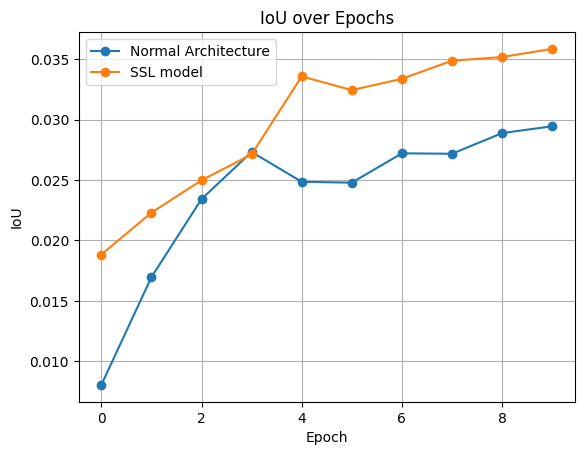

In [29]:
epochs = range(len(valEpochIOU))

plt.plot(epochs, valEpochIOU, marker='o', label='Normal Architecture')
plt.plot(epochs, valEpochIOU_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU over Epochs')
plt.legend()
plt.grid(True)
plt.show()

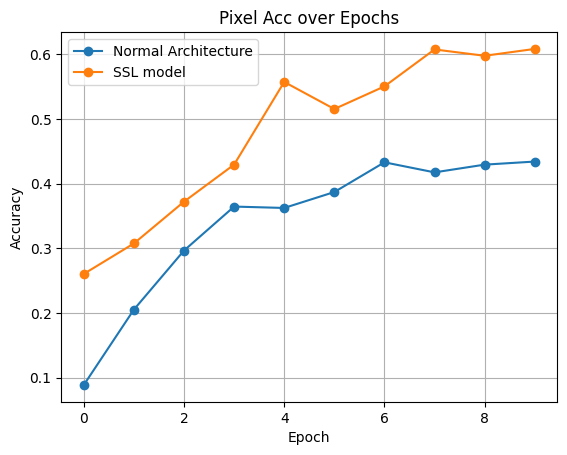

In [30]:
plt.plot(epochs, valEpochAccuracy, marker='o', label='Normal Architecture')
plt.plot(epochs, valEpochAccuracy_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Pixel Acc over Epochs')
plt.legend()
plt.grid(True)
plt.show()

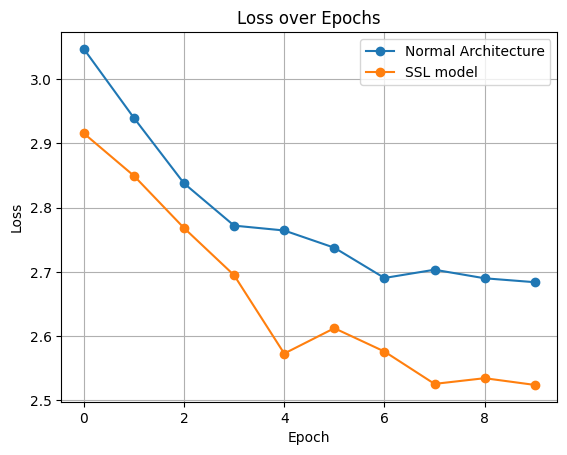

In [31]:
plt.plot(epochs, valEpochLoss, marker='o', label='Normal Architecture')
plt.plot(epochs, valEpochLoss_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
torch.save(model.state_dict(), 'ssl_model.pth')